# Определение перспективного тарифа для телеком компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей<br>
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<br>
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей<br>
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

## Описание данных

1. Таблица `users` (информация о пользователях):
    - *user_id* — уникальный идентификатор пользователя
    - *first_name* — имя пользователя
    - *last_name* — фамилия пользователя
    - *age* — возраст пользователя (годы)
    - *reg_date* — дата подключения тарифа (день, месяц, год)
    - *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    - *city* — город проживания пользователя
    - *tariff* — название тарифного плана


2. Таблица `calls` (информация о звонках):
    - *id* — уникальный номер звонка
    - *call_date* — дата звонка
    - *duration* — длительность звонка в минутах
    - *user_id* — идентификатор пользователя, сделавшего звонок


3. Таблица `messages` (информация о сообщениях):
    - *id* — уникальный номер сообщения
    - *message_date* — дата сообщения
    - *user_id* — идентификатор пользователя, отправившего сообщение


4. Таблица `internet` (информация об интернет-сессиях):
    - *id* — уникальный номер сессии
    - *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
    - *session_date* — дата интернет-сессии
    - *user_id* — идентификатор пользователя


5. Таблица `tariffs` (информация о тарифах):
    - *tariff_name* — название тарифа
    - *rub_monthly_fee* — ежемесячная абонентская плата в рублях
    - *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
    - *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
    - *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    - *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    - *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
    - *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Оглавление

1. [Открытие и изучение файлов с данными](#step1)
2. [Предобработка данных](#step2)
3. [Анализ данных](#step3)
4. [Проверка гипотез](#step4)
5. [Общий вывод](#step5)

<a id="step1"></a>
## 1. Открытие и изучение файлов с данными

На данном шаге прочитаем данные из всех файлов и ознакомимся с ними.

In [1]:
# подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st
from IPython.display import display

In [2]:
# Прочитаем файл с информацией о звонках
calls = pd.read_csv('calls.csv')

# выведем информацию о таблице
print(calls.columns)
print()
calls.info()

# выведем первые 10 строк
display(calls.head(10))

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Таблица с информацией о звонках: в названиях колонок лишних пробелов нет, все на латинице, пропущенных значений нет. В колонке с датой (`call_date`) неверно определяется тип данных - в дальнейшем необходимо обработать. Всего 202607 строки.

In [3]:
# Прочитаем файл с информацией об интернет-сессиях
internet = pd.read_csv('internet.csv')

# выведем информацию о таблице
print(internet.columns)
print()
internet.info()

# выведем первые 10 строк
display(internet.head(10))

# выведем последние 10 строк
display(internet.tail(10))

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


,Unnamed: 0,id,mb_used,session_date,user_id
149386,149386,1499_147,0.00,2018-10-21,1499
149387,149387,1499_148,268.19,2018-11-13,1499
149388,149388,1499_149,778.68,2018-11-24,1499
149389,149389,1499_150,273.98,2018-11-20,1499
149390,149390,1499_151,752.72,2018-10-11,1499
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


Таблица с информацией об интернет-сессиях: в названиях колонок лишних пробелов нет, все на латинице, пропущенных значений нет. Появился столбец `Unnamed: 0`. Из полученного описания предполагаемых таблиц видно, что такой столбец не ожидается. Судя по всему, он дублирует индекс в таблице и попал в файл по случайности. В дальнейшем необходимо будет разобраться, что с ним делать. Также для колонки с датой (`session_date`) неверно указан тип данных. Всего 149396 строки.

In [4]:
# Прочитаем файл с информацией о сообщениях
messages = pd.read_csv('messages.csv')

# выведем информацию о таблице
print(messages.columns)
print()
messages.info()

# выведем первые 10 строк
display(messages.head(10))

Index(['id', 'message_date', 'user_id'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Таблица с информацией о сообщениях: в названиях колонок лишних пробелов нет, все на латинице, пропущенных значений нет. Для колонки с датой (`message_date`) неверно указан тип данных. Всего 123036 строки.

In [5]:
# Прочитаем файл с информацией о тарифах
tariffs = pd.read_csv('tariffs.csv')

# выведем информацию о таблице
print(tariffs.columns)
print()
tariffs.info()

# выведем первые 10 строк
display(tariffs.head(10))

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Как и следовало ожидать, у нас всего два тарифа - в таблице всего две строки. Названия колонок верные, без лишних пробелов, на латинице. Типы данных также у всех колонок верные.

In [6]:
# Прочитаем файл с информацией о пользователях
users = pd.read_csv('users.csv')

# выведем информацию о таблице
print(users.columns)
print()
users.info()

# выведем первые 10 строк
display(users.head(10))

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Таблица с информацией о пользователях: в названиях колонок лишних пробелов нет, все на латинице. Есть пропущенные значения в колонке `churn_date` (дата прекращения пользования тарифом), но это ожидаемые пропуски. Для колонки с датой (`reg_date`) неверно указан тип данных. Всего 500 строк.

### Вывод

На данном шаге было произведено считывание данных из файлов (всего 5), сохранение информации в таблицы. Было проведено первичное ознакомление с данными. Были вынесены предложения по корректировке данных (изменить тип данных некоторых столбцов, убрать лишний столбец).<br>
В целом, данные из файлов - качественные. Пропусков практически нет, за исключением ожидаемых. Грубых ошибок нет, что ожидается в колонке, то и хранится.

<a id="step2"></a>
## 2. Предобработка данных

Как было определено на предыдущем шаге, в колонках с датами, неверно определяется тип данных. На данный момент это - object. Поскольку мы знаем, что там должны лежать даты, изменим это.

In [7]:
# изменим тип данных для столбца call_date из calls
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(calls.dtypes)
print()

# изменим тип данных для столбца session_date из internet
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
print(internet.dtypes)
print()

# изменим тип данных для столбца message_date из messages
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
print(messages.dtypes)
print()

# изменим тип данных для столбца reg_date из users
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
print(users.dtypes)

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

Unnamed: 0               int64
id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

user_id                int64
age                    int64
churn_date            object
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object


Также по условию задачи сказано, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Значит необходимо округлить до большего ближайшего целого значения столбцов `duration` (в **calls**) и `mb_used` (в **internet**), а после этого заменить тип данных на int (т.к. там будут храниться целые значения).

In [8]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)
print(calls.dtypes)
print()

internet['mb_used'] = np.ceil(internet['mb_used'])
internet['mb_used'] = internet['mb_used'].astype(int)
print(internet.dtypes)
print()

id                   object
call_date    datetime64[ns]
duration              int32
user_id               int64
dtype: object

Unnamed: 0               int64
id                      object
mb_used                  int32
session_date    datetime64[ns]
user_id                  int64
dtype: object



На предыдущем шаге также было замечено, что в таблице **internet** появлися неожидаемый столбец `Unnamed: 0` - удалим его.

In [9]:
# удалим ненужный столбец
internet = internet.drop('Unnamed: 0', axis='columns')
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


Рассмотрим таблицы на наличие ошибок. Первой рассмотрим таблицу звонков **calls**.

Quantity of calls with zero duration = 39613
Quantity of all calls = 202607
Propotion = 19.551644%

All calls
count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64


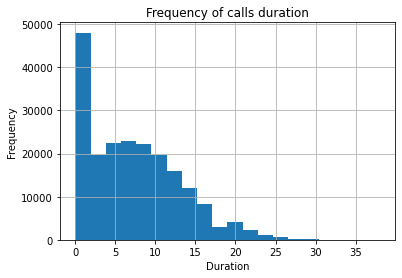

Calls with duration
count    162994.000000
mean          8.897880
std           5.353761
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

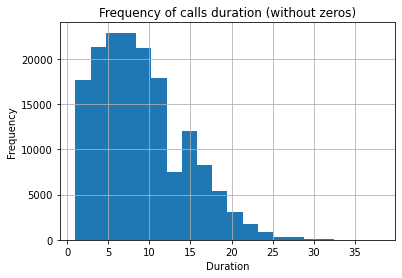

In [10]:
calls_with_zero_duration = calls.query('duration == 0')
print('Quantity of calls with zero duration =', calls_with_zero_duration['duration'].size)
print('Quantity of all calls =', calls['duration'].size)
print('Propotion = {:%}'.format(calls_with_zero_duration['duration'].size / calls['duration'].size))
print()

calls_with_duration = calls.query('duration != 0').copy()

print("All calls")
print(calls['duration'].describe())
calls['duration'].hist(bins=20)
plt.title('Frequency of calls duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

print("Calls with duration")
print(calls_with_duration['duration'].describe())
calls_with_duration['duration'].hist(bins=20)
plt.title('Frequency of calls duration (without zeros)')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show

Мы посмотрели, сколько звонков с длительностью 0.0 минут - 39613. Скорее всего - это пропущенные звонки. Общее количество записей в таблице - 202607, соответственно это общее количество звонков. Таким образом чуть менее 20% звонков пропущены. Вывели описание данных и постороили гисторграммы для обоих датасетов. Из первого графика видно, что если брать в расчет абсолютно все данные по длительности звонков, то у нас появляется пик в 0. Явно это нехарактерное значение для распределения. Также видно, как он влияет на среднее значение: 7.2 (для всех) и 8,9 (без нулей в длительности). В дальнейшем, необходимо учитывать этот факт.<br>
Сохранили таблицу, без 0 в длительности, в переменной calls_with_duration. 

Рассмотри таблицу для интернет-сессий.

Quantity of zero mb_used sessions = 19598
Quantity of all sessions = 149396
Propotion = 13.118156%

All internet
count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64


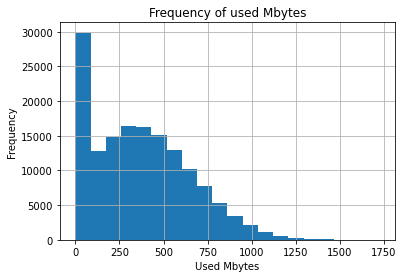

Internet wirh mb_used
count    129798.000000
mean        426.581758
std         255.596114
min           1.000000
25%         228.000000
50%         401.000000
75%         593.000000
max        1725.000000
Name: mb_used, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

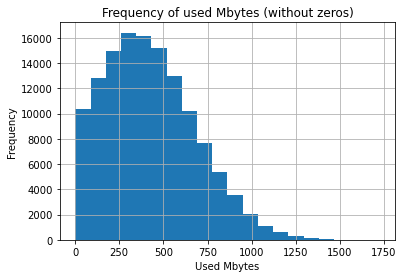

In [11]:
internet_with_zero_mb_used = internet.query('mb_used == 0')
print('Quantity of zero mb_used sessions =', internet_with_zero_mb_used['mb_used'].size)
print('Quantity of all sessions =', internet['mb_used'].size)
print('Propotion = {:%}'.format(internet_with_zero_mb_used['mb_used'].size / internet['mb_used'].size))
print()

internet_with_mb_used = internet.query('mb_used != 0').copy()

print("All internet")
print(internet['mb_used'].describe())
internet['mb_used'].hist(bins=20)
plt.title('Frequency of used Mbytes')
plt.xlabel('Used Mbytes')
plt.ylabel('Frequency')
plt.show()

print("Internet wirh mb_used")
print(internet_with_mb_used['mb_used'].describe())
internet_with_mb_used['mb_used'].hist(bins=20)
plt.title('Frequency of used Mbytes (without zeros)')
plt.xlabel('Used Mbytes')
plt.ylabel('Frequency')
plt.show

Аналогичная ситуация с интернет соединениями и объемом потраченного трафика. 13% от всего трафика без передачи данных (то есть 0 Mbyte). Вероятно, отсутствовало интернет соединение или была ошибка при подключении. Среднее значение также смещено в меньшую сторону: 370.6 (для всех данных) и 426,6 (для данных без нулей). В дальнейшем стоит не учитывать нулевые значения.<br>
Таблица сохранена в переменной internet_with_mb_used

Рассмотрим таблицу с информацией и сообщениях

In [12]:
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


В данной таблице, ошибок нет. Столбцов с нулевыми значениями нет - идентификаторы и дата.

Рассмотрим таблицу с информацией о тарифах.

In [13]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В данной таблице ошибок нет. Нет значений, которые могли бы исказить дальнейший анализ.

Рассмотрим основную таблицу с информацией о пользователях.

In [14]:
users.info()

display(users.head(10))

print('check "age" column')
print('min age =', users['age'].min())
print('max age =', users['age'].max())
print()

print('check "churn_date" column')
display(users['churn_date'].value_counts())
print()

print('check "tariff" column')
display(users['tariff'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


check "age" column
min age = 18
max age = 75

check "churn_date" column


2018-12-09    2
2018-12-21    2
2018-10-03    2
2018-12-03    2
2018-10-14    2
2018-11-30    1
2018-10-05    1
2018-10-04    1
2018-12-11    1
2018-12-20    1
2018-10-25    1
2018-08-17    1
2018-11-21    1
2018-11-22    1
2018-12-30    1
2018-08-31    1
2018-09-27    1
2018-11-07    1
2018-12-26    1
2018-12-14    1
2018-12-24    1
2018-09-26    1
2018-12-18    1
2018-12-16    1
2018-12-25    1
2018-11-26    1
2018-11-16    1
2018-09-02    1
2018-11-27    1
2018-11-13    1
2018-10-27    1
2018-10-28    1
2018-12-23    1
Name: churn_date, dtype: int64


check "tariff" column


smart    351
ultra    149
Name: tariff, dtype: int64

Мы вывели информацию о таблице и первые 10 строк. Как уже было указано ранее, в столбце `churn_date` (дата прекращения пользования тарифом) есть пропущенные значения, но они имеют смысл - указывают, что на момент выгрузки данных тариф еще действовал. Поэтому оставим этот столбец без изменений. Отдельно проверили колонку `age` на адекватные значения (чтобы не было очень больших или очень маленьких чисел), еще раз столбец с датой прекращения на адекватные значения (что дата реальная, а не какая-то абстрактная дата из другого века), столбец тариф (что присутствует только два рассматриваемых тарифа).

Посчитаем и добавим дополнительную информацию для каждого пользователя. Она будет полезна при дальнейшем анализе.

Для каждого пользователя посчитаем:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

In [15]:
# добавим колонку с месяцем в таблицу calls
calls_with_duration['month'] = calls_with_duration['call_date'].dt.month

# добавим колонку с месяцем в таблицу messages
messages['month'] = messages['message_date'].dt.month

# добавим колонку с месяцем в таблицу internet
internet_with_mb_used['month'] = internet_with_mb_used['session_date'].dt.month

In [16]:
# объединим таблицы по правилу outer, чтобы в таблице остались все значения user_id (из одной и из второй таблицы)
    # calls_with_duration - таблица без нулевых значений
full_data = users.merge(calls_with_duration, on='user_id', how='outer')
display(full_data.head(10))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0,6.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0,9.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0,12.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_7,2018-08-22,19.0,8.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_8,2018-09-15,19.0,9.0
5,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_10,2018-08-22,6.0,8.0
6,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_11,2018-05-28,19.0,5.0
7,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_12,2018-07-05,3.0,7.0
8,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_13,2018-09-29,8.0,9.0
9,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_14,2018-12-11,10.0,12.0


In [17]:
# в переменную full_data_gp сохраним данные сгруппированные по user_id и month, 
    # а также посчитаем количество звонков и израсходованных минут разговора по месяцам
full_data_gp = full_data.pivot_table(index = ['user_id', 'month'], aggfunc={'duration': sum, 'id': 'count'})
# переименуем эти столбцы
full_data_gp.columns = ['sum_calls_duration', 'num_of_calls']
display(full_data_gp.head(10))

sum_calls_duration  num_of_calls
user_id month                                  
1000    5.0                 159.0            17
        6.0                 172.0            28
        7.0                 340.0            41
        8.0                 408.0            42
        9.0                 466.0            46
        10.0                350.0            44
        11.0                338.0            37
        12.0                333.0            38
1001    11.0                430.0            45
        12.0                414.0            47

In [18]:
# во временной таблице объединим данные из сообщений
messages_data = full_data_gp.merge(messages, on=['user_id', 'month'], how='outer')
display(messages_data.head(10))

,user_id,month,sum_calls_duration,num_of_calls,id,message_date
0,1000,5.0,159.0,17.0,1000_10,2018-05-30
1,1000,5.0,159.0,17.0,1000_19,2018-05-29
2,1000,5.0,159.0,17.0,1000_20,2018-05-28
3,1000,5.0,159.0,17.0,1000_63,2018-05-28
4,1000,5.0,159.0,17.0,1000_96,2018-05-30
5,1000,5.0,159.0,17.0,1000_139,2018-05-25
6,1000,5.0,159.0,17.0,1000_162,2018-05-27
7,1000,5.0,159.0,17.0,1000_202,2018-05-27
8,1000,5.0,159.0,17.0,1000_258,2018-05-25
9,1000,5.0,159.0,17.0,1000_296,2018-05-29


In [19]:
# также сгруппируем данные по user_id и month, а также посчитаем количество отправленных сообщений по месяцам
messages_data_gp = messages_data.pivot_table(index = ['user_id', 'month'], aggfunc={'id': 'count'})
messages_data_gp.columns = ['num_of_messages']
display(messages_data_gp.head(10))

num_of_messages
user_id month                 
1000    5.0                 22
        6.0                 60
        7.0                 75
        8.0                 81
        9.0                 57
        10.0                73
        11.0                58
        12.0                70
1001    11.0                 0
        12.0                 0

In [20]:
# добавим полученные данные в таблицу full_data_gp
full_data_gp = full_data_gp.merge(messages_data_gp, on=['user_id', 'month'], how='outer')
display(full_data_gp.head(10))

sum_calls_duration  num_of_calls  num_of_messages
user_id month                                                   
1000    5.0                 159.0          17.0               22
        6.0                 172.0          28.0               60
        7.0                 340.0          41.0               75
        8.0                 408.0          42.0               81
        9.0                 466.0          46.0               57
        10.0                350.0          44.0               73
        11.0                338.0          37.0               58
        12.0                333.0          38.0               70
1001    11.0                430.0          45.0                0
        12.0                414.0          47.0                0

In [21]:
# во временной таблице объединим данные по интернету (таблица без нулевых значений)
internet_data = full_data_gp.merge(internet_with_mb_used, on=['user_id', 'month'], how='outer')
display(internet_data.head(10))

,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,id,mb_used,session_date
0,1000,5.0,159.0,17.0,22.0,1000_51,629.0,2018-05-31
1,1000,5.0,159.0,17.0,22.0,1000_59,364.0,2018-05-28
2,1000,5.0,159.0,17.0,22.0,1000_96,545.0,2018-05-28
3,1000,5.0,159.0,17.0,22.0,1000_134,718.0,2018-05-31
4,1000,6.0,172.0,28.0,60.0,1000_2,1198.0,2018-06-25
5,1000,6.0,172.0,28.0,60.0,1000_12,376.0,2018-06-20
6,1000,6.0,172.0,28.0,60.0,1000_16,460.0,2018-06-09
7,1000,6.0,172.0,28.0,60.0,1000_17,205.0,2018-06-03
8,1000,6.0,172.0,28.0,60.0,1000_25,154.0,2018-06-17
9,1000,6.0,172.0,28.0,60.0,1000_30,578.0,2018-06-09


In [22]:
# также сгруппируем данные по user_id и month, а также посчитаем объем израсходованного интернет-трафика по месяцам
internet_data_gp = internet_data.pivot_table(index = ['user_id', 'month'], aggfunc={'mb_used': sum})
internet_data_gp.columns = ['sum_of_mb_used']
display(internet_data_gp.head(10))

sum_of_mb_used
user_id month                
1000    5.0            2256.0
        6.0           23257.0
        7.0           14016.0
        8.0           14070.0
        9.0           14581.0
        10.0          14717.0
        11.0          14768.0
        12.0           9827.0
1001    11.0          18452.0
        12.0          14053.0

In [23]:
# добавим полученные данные в таблицу full_data_gp
full_data_gp = full_data_gp.merge(internet_data_gp, on=['user_id', 'month'], how='outer')
display(full_data_gp.head(10))
full_data_gp.info()

sum_calls_duration  num_of_calls  num_of_messages  \
user_id month                                                      
1000    5.0                 159.0          17.0             22.0   
        6.0                 172.0          28.0             60.0   
        7.0                 340.0          41.0             75.0   
        8.0                 408.0          42.0             81.0   
        9.0                 466.0          46.0             57.0   
        10.0                350.0          44.0             73.0   
        11.0                338.0          37.0             58.0   
        12.0                333.0          38.0             70.0   
1001    11.0                430.0          45.0              0.0   
        12.0                414.0          47.0              0.0   

               sum_of_mb_used  
user_id month                  
1000    5.0            2256.0  
        6.0           23257.0  
        7.0           14016.0  
        8.0           14070.0  
        9.0           14581.0  
        10.0          14717.0  
        11.0          14768.0  
        12.0           9827.0  
1001    11.0          18452.0  
        12.0          14053.0

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5.0) to (1476, 4.0)
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_calls_duration  3168 non-null   float64
 1   num_of_calls        3168 non-null   float64
 2   num_of_messages     3212 non-null   float64
 3   sum_of_mb_used      3214 non-null   float64
dtypes: float64(4)
memory usage: 134.3 KB


Из полученной таблицы видно, что в ней есть пропущенные значения. Они взялись из-за того, что при объединении по двум полям (`user_id` и `month`) в режиме outer может возникнуть случай, когда в одной таблице значение есть,а в другой - нет. Посмотрим подробнее на эти пропуски.

In [24]:
print(full_data_gp.isnull().sum())

display(full_data_gp.loc[
    full_data_gp['sum_calls_duration'].isnull() | 
    full_data_gp['num_of_calls'].isnull() |
    full_data_gp['num_of_messages'].isnull()
])

sum_calls_duration    46
num_of_calls          46
num_of_messages        2
sum_of_mb_used         0
dtype: int64


sum_calls_duration  num_of_calls  num_of_messages  \
user_id month                                                      
1091    5.0                   NaN           NaN             30.0   
        6.0                   NaN           NaN             30.0   
        7.0                   NaN           NaN             35.0   
        8.0                   NaN           NaN             31.0   
        9.0                   NaN           NaN             32.0   
        10.0                  NaN           NaN             44.0   
        11.0                  NaN           NaN             28.0   
        12.0                  NaN           NaN             42.0   
1106    4.0                   NaN           NaN              9.0   
        5.0                   NaN           NaN             28.0   
        6.0                   NaN           NaN             30.0   
        7.0                   NaN           NaN             24.0   
        8.0                   NaN           NaN             25.0   
        9.0                   NaN           NaN             23.0   
        10.0                  NaN           NaN             33.0   
        11.0                  NaN           NaN             29.0   
        12.0                  NaN           NaN             24.0   
1231    5.0                   NaN           NaN             55.0   
        6.0                   NaN           NaN            201.0   
        7.0                   NaN           NaN            211.0   
        8.0                   NaN           NaN            180.0   
        9.0                   NaN           NaN            188.0   
        10.0                  NaN           NaN            185.0   
        11.0                  NaN           NaN            173.0   
        12.0                  NaN           NaN            191.0   
1257    7.0                   NaN           NaN            146.0   
        8.0                   NaN           NaN            157.0   
        9.0                   NaN           NaN            153.0   
1328    10.0                  NaN           NaN              6.0   
        11.0                  NaN           NaN              8.0   
        12.0                  NaN           NaN              7.0   
1373    1.0                   NaN           NaN             28.0   
        4.0                   NaN           NaN             48.0   
        6.0                   NaN           NaN             48.0   
1473    8.0                   NaN           NaN             17.0   
        9.0                   NaN           NaN             19.0   
        10.0                  NaN           NaN             20.0   
        11.0                  NaN           NaN             14.0   
        12.0                  NaN           NaN             20.0   
1489    8.0                   NaN           NaN             17.0   
        9.0                   NaN           NaN             32.0   
        10.0                  NaN           NaN             21.0   
        11.0                  NaN           NaN             20.0   
        12.0                  NaN           NaN             35.0   
1240    2.0                   NaN           NaN              NaN   
1476    4.0                   NaN           NaN              NaN   

               sum_of_mb_used  
user_id month                  
1091    5.0           10714.0  
        6.0           10245.0  
        7.0           16460.0  
        8.0           12644.0  
        9.0           16611.0  
        10.0          15659.0  
        11.0          11876.0  
        12.0          13292.0  
1106    4.0            2925.0  
        5.0           16591.0  
        6.0           20036.0  
        7.0           21647.0  
        8.0           19105.0  
        9.0           21953.0  
        10.0          14021.0  
        11.0          21311.0  
        12.0          18722.0  
1231    5.0           10868.0  
        6.0           27850.0  
        7.0           27718.0  
        8.0           32075.0  
        9.0   

Заполним эти пропуски нулями. Это будет соответствовать, что в данном месяца эта информация не производилась.

In [25]:
full_data_gp['sum_calls_duration'] = full_data_gp['sum_calls_duration'].fillna(0)
full_data_gp['num_of_calls'] = full_data_gp['num_of_calls'].fillna(0)
full_data_gp['num_of_messages'] = full_data_gp['num_of_messages'].fillna(0)

print(full_data_gp.isnull().sum())

sum_calls_duration    0
num_of_calls          0
num_of_messages       0
sum_of_mb_used        0
dtype: int64


Также в эту таблицу нужно добавить используемый пользователем тариф.

In [26]:
# выделим в отдельную таблицу соответствие user_id тарифу
user_tariff_table = users[['user_id', 'tariff']]

full_data_gp = full_data_gp.join(user_tariff_table.set_index('user_id'))
display(full_data_gp.head())

sum_calls_duration  num_of_calls  num_of_messages  \
user_id month                                                      
1000    5.0                 159.0          17.0             22.0   
        6.0                 172.0          28.0             60.0   
        7.0                 340.0          41.0             75.0   
        8.0                 408.0          42.0             81.0   
        9.0                 466.0          46.0             57.0   

               sum_of_mb_used tariff  
user_id month                         
1000    5.0            2256.0  ultra  
        6.0           23257.0  ultra  
        7.0           14016.0  ultra  
        8.0           14070.0  ultra  
        9.0           14581.0  ultra

In [27]:
full_data_gp.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5.0) to (1476, 4.0)
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_calls_duration  3214 non-null   float64
 1   num_of_calls        3214 non-null   float64
 2   num_of_messages     3214 non-null   float64
 3   sum_of_mb_used      3214 non-null   float64
 4   tariff              3214 non-null   object 
dtypes: float64(4), object(1)
memory usage: 159.4+ KB


Видно, что типы данных столбцов - вещественные числа. Это произошло из-за появлении значений NaN в столбцах. Приведем к правильному типу данных. Также сбросим индекс для удобства дальнейшей работы.

In [28]:
full_data_gp = full_data_gp.reset_index()

full_data_gp['month'] = full_data_gp['month'].astype(int)
full_data_gp['sum_calls_duration'] = full_data_gp['sum_calls_duration'].astype(int)
full_data_gp['num_of_calls'] = full_data_gp['num_of_calls'].astype(int)
full_data_gp['num_of_messages'] = full_data_gp['num_of_messages'].astype(int)
full_data_gp['sum_of_mb_used'] = full_data_gp['sum_of_mb_used'].astype(int)

full_data_gp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             3214 non-null   int64 
 1   month               3214 non-null   int32 
 2   sum_calls_duration  3214 non-null   int32 
 3   num_of_calls        3214 non-null   int32 
 4   num_of_messages     3214 non-null   int32 
 5   sum_of_mb_used      3214 non-null   int32 
 6   tariff              3214 non-null   object
dtypes: int32(5), int64(1), object(1)
memory usage: 113.1+ KB


In [29]:
full_data_gp.head()

,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,sum_of_mb_used,tariff
0,1000,5,159,17,22,2256,ultra
1,1000,6,172,28,60,23257,ultra
2,1000,7,340,41,75,14016,ultra
3,1000,8,408,42,81,14070,ultra
4,1000,9,466,46,57,14581,ultra


Посчитаем помесячную выручку с каждого пользователя. Для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

In [30]:
def count_revenue(row):
    income_calls = 0
    income_messages = 0
    cur_tariff = row['tariff']
    fee = tariffs.query('tariff_name == @cur_tariff')['rub_monthly_fee'].values[0]
    
    income_calls = row['sum_calls_duration'] - tariffs.query('tariff_name == @cur_tariff')['minutes_included'].values[0]
    if income_calls < 0:
        income_calls = 0
    income_calls *= tariffs.query('tariff_name == @cur_tariff')['rub_per_minute'].values[0]
    
    income_messages = row['num_of_messages'] - tariffs.query('tariff_name == @cur_tariff')['messages_included'].values[0]
    if income_messages < 0:
        income_messages = 0
    income_messages *= tariffs.query('tariff_name == @cur_tariff')['rub_per_message'].values[0]
    
    income_internet = row['sum_of_mb_used'] - tariffs.query('tariff_name == @cur_tariff')['mb_per_month_included'].values[0]
    if income_internet < 0:
        income_internet = 0
    else:
        # переведем в гигабайты
        income_internet /= 1024
        income_internet = np.ceil(income_internet)
    income_internet *= tariffs.query('tariff_name == @cur_tariff')['rub_per_gb'].values[0]
    
    return fee + income_calls + income_messages + income_internet


full_data_gp['count_revenue'] = full_data_gp.apply(count_revenue, axis=1)

В итоге получили сводную таблицу, со всей необходимой информаией для анализа.

In [31]:
full_data_gp.head(10)

,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,sum_of_mb_used,tariff,count_revenue
0,1000,5,159,17,22,2256,ultra,1950.0
1,1000,6,172,28,60,23257,ultra,1950.0
2,1000,7,340,41,75,14016,ultra,1950.0
3,1000,8,408,42,81,14070,ultra,1950.0
4,1000,9,466,46,57,14581,ultra,1950.0
5,1000,10,350,44,73,14717,ultra,1950.0
6,1000,11,338,37,58,14768,ultra,1950.0
7,1000,12,333,38,70,9827,ultra,1950.0
8,1001,11,430,45,0,18452,smart,1350.0
9,1001,12,414,47,0,14053,smart,550.0


### Вывод

На данном шаге производилась подготовка данных для анализа. Сначала данные были приведены к правильним типам данных, а также были удалены некорректные столбцы. После, в соответствии с особенностями задачи, данные были отредактированы. После чего проводилась проверка на адекватность значений данных. Были обработаны нулевые значения в колонках, на гистограммах было показано, как эти значения влияют на распределения. В результате, было принято решение, что нулевые значения не стоит включать в дальнейший анализ. Для дальнейшего анализа была собрана таблица, содержащая всю важную информацию.

<a id="step3"></a>
## 3. Анализ данных

Проанализируем сколько минут разговора требуется пользователям каждого тарифа в месяц.

In [32]:
# получим таблицу для каждого тарифа
smart_tariff = full_data_gp.query('tariff == "smart"')
ultra_tariff = full_data_gp.query('tariff == "ultra"')

display(smart_tariff.head())
display(ultra_tariff.head())

,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,sum_of_mb_used,tariff,count_revenue
8,1001,11,430,45,0,18452,smart,1350.0
9,1001,12,414,47,0,14053,smart,550.0
10,1002,6,117,14,4,10871,smart,550.0
11,1002,7,214,21,11,17601,smart,1150.0
12,1002,8,289,37,13,20347,smart,1550.0


,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,sum_of_mb_used,tariff,count_revenue
0,1000,5,159,17,22,2256,ultra,1950.0
1,1000,6,172,28,60,23257,ultra,1950.0
2,1000,7,340,41,75,14016,ultra,1950.0
3,1000,8,408,42,81,14070,ultra,1950.0
4,1000,9,466,46,57,14581,ultra,1950.0


Посчитаем среднее количество, дисперсию и стандартное отклонение для звонков для каждого месяца для обоих тарифов

In [33]:
call_month_sm_tr = smart_tariff[['month', 'sum_calls_duration']]
call_month_sm_tr_stat = (
    call_month_sm_tr
        .groupby('month')
        .agg({'sum_calls_duration': [np.mean, lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]})
        .reset_index()
)
call_month_sm_tr_stat.columns = ['month', 'duration_mean', 'duration_var', 'duration_std']
call_month_sm_tr_stat

,month,duration_mean,duration_var,duration_std
0,1,203.852941,23787.341355,154.231454
1,2,298.689655,36412.287961,190.820041
2,3,390.051948,36823.155161,191.893604
3,4,367.133929,34778.207127,186.489161
4,5,387.361702,34820.061094,186.601343
5,6,395.640244,30742.918861,175.336587
6,7,408.353234,32250.269602,179.583601
7,8,421.468085,34793.583379,186.530382
8,9,428.611538,33535.342723,183.126576
9,10,426.136054,35392.336375,188.128510


In [34]:
call_month_ul_tr = ultra_tariff[['month', 'sum_calls_duration']]
call_month_ul_tr_stat = (
    call_month_ul_tr
        .groupby('month')
        .agg({'sum_calls_duration': [np.mean, lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]})
        .reset_index()
)
call_month_ul_tr_stat.columns = ['month', 'duration_mean', 'duration_var', 'duration_std']
call_month_ul_tr_stat

,month,duration_mean,duration_var,duration_std
0,1,428.111111,72769.361111,269.757968
1,2,297.125000,87919.679348,296.512528
2,3,489.648649,111384.900901,333.743765
3,4,458.018182,71653.870034,267.682405
4,5,510.328358,83870.193578,289.603511
5,6,479.702381,91535.946500,302.549081
6,7,545.791209,94322.278144,307.119322
7,8,510.775701,97956.496385,312.980026
8,9,539.443478,105716.775286,325.141162
9,10,558.081301,106464.583500,326.289110


Построим для среднего гистограмму по месяцам

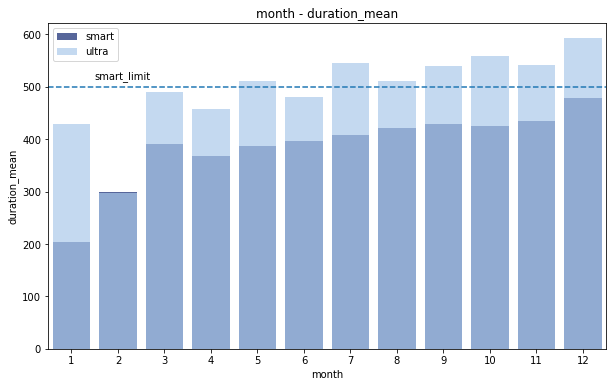

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.set_color_codes('dark')
sns.barplot(data=call_month_sm_tr_stat, x='month', y='duration_mean', color='b', alpha=0.7, label='smart', \
            capsize=200)

sns.set_color_codes('pastel')
sns.barplot(data=call_month_ul_tr_stat, x='month', y='duration_mean', color='b', alpha=0.7, label='ultra')

ax.set_title('month - duration_mean')
ax.axhline(500, ls='--')
ax.text(0.5, 515, "smart_limit")
ax.legend(ncol=1)

На данной гистограмме выведена информация о средней продолжительности разговора (в минутах) в зависимости от месяца для каждого из анализируемых тарифов. Также указано включенное количество минут для тарифа smart (500 минут). Для тарифа ultra данный показатель намного больше (3000 минут), было решено его не выводить на график по причине ненаглядности остальной картины.
Как видно из графика, в среднем данный лимит на разговоры для тарифа smart не превышается. Люди следят за этим показателем, чтобы не платить дополнительные деньги. Для тарифа ultra количество минут ограничено бОльшим числом, но как видно из графика, реальное значение многим меньше и оно близко к границе smart. Сейчас люди не разговаривают столько времени.

Таким образом можно сделать вывод: по данному показателю люди будут выбирать скорее тариф smart, так как ограничение на количество минут входящее в абонентскую плату покрывает их потребности.

Посчитаем среднее количество, дисперсию и стандартное отклонение для количества сообщений для каждого месяца для обоих тарифов

In [36]:
message_month_sm_tr = smart_tariff[['month', 'num_of_messages']]
message_month_sm_tr_stat = (
    message_month_sm_tr
        .groupby('month')
        .agg({'num_of_messages': [np.mean, lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]})
        .reset_index()
)
message_month_sm_tr_stat.columns = ['month', 'messages_mean', 'messages_var', 'messages_std']
message_month_sm_tr_stat

,month,messages_mean,messages_var,messages_std
0,1,18.235294,262.367201,16.197753
1,2,24.086207,473.097701,21.750809
2,3,31.857143,718.492481,26.804710
3,4,30.741071,602.139559,24.538532
4,5,33.773050,730.990983,27.036845
5,6,33.402439,806.806374,28.404337
6,7,33.751244,799.887811,28.282288
7,8,33.638298,838.257501,28.952677
8,9,33.638462,790.617820,28.117927
9,10,33.765306,816.111966,28.567673


In [37]:
message_month_ul_tr = ultra_tariff[['month', 'num_of_messages']]
message_month_ul_tr_stat = (
    message_month_ul_tr
        .groupby('month')
        .agg({'num_of_messages': [np.mean, lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]})
        .reset_index()
)
message_month_ul_tr_stat.columns = ['month', 'messages_mean', 'messages_var', 'messages_std']
message_month_ul_tr_stat

,month,messages_mean,messages_var,messages_std
0,1,33.777778,940.694444,30.670742
1,2,21.958333,716.824275,26.773574
2,3,32.297297,1732.381381,41.621886
3,4,31.563636,1407.287542,37.513831
4,5,37.850746,1624.644052,40.306874
5,6,41.726190,1986.297619,44.567899
6,7,49.846154,2372.042735,48.703621
7,8,48.439252,2171.739199,46.601923
8,9,52.286957,2152.855530,46.398874
9,10,58.430894,2697.181661,51.934398


Построим для среднего гистограмму по месяцам

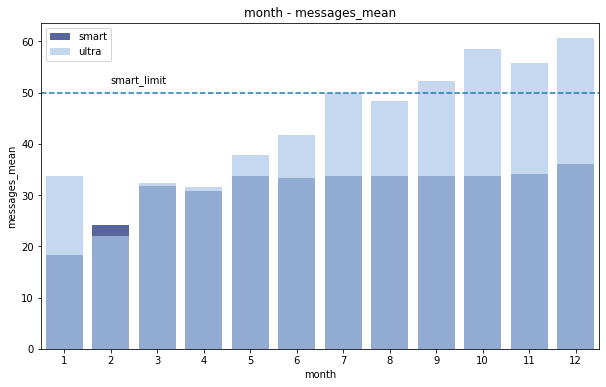

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.set_color_codes('dark')
sns.barplot(data=message_month_sm_tr_stat, x='month', y='messages_mean', color='b', alpha=0.7, label='smart', \
            capsize=200)

sns.set_color_codes('pastel')
sns.barplot(data=message_month_ul_tr_stat, x='month', y='messages_mean', color='b', alpha=0.7, label='ultra')

ax.set_title('month - messages_mean')
ax.axhline(50, ls='--')
ax.text(1, 52, "smart_limit")
ax.legend(ncol=1)

На данной гистограмме показано сколько сообщений в среднем отправляют пользователи разных тарифов в зависимости от месяца. Видно что пользователи используют меньше сообщений, чем могут. Это касается обоих тарифов, что smart (50), что ultra (1000). Как и для звонков, по этому показателю люди будут скорее выбирать тариф smart, так как он с излишком покрывает их потребности. Для людей же, которые много пользуются сообщениями лучше будет заплатить сверх абонентской платы за дополнительные сообщения, чем покупать пакет из 1000, которыми они точно не воспользуются.

Посчитаем среднее количество, дисперсию и стандартное отклонение для объема интернет трафика для каждого месяца для обоих тарифов

In [39]:
internet_month_sm_tr = smart_tariff[['month', 'sum_of_mb_used']]
internet_month_sm_tr_stat = (
    internet_month_sm_tr
        .groupby('month')
        .agg({'sum_of_mb_used': [np.mean, lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]})
        .reset_index()
)
internet_month_sm_tr_stat.columns = ['month', 'mb_used_mean', 'mb_used_var', 'mb_used_std']
internet_month_sm_tr_stat

,month,mb_used_mean,mb_used_var,mb_used_std
0,1,8524.441176,4.162621e+07,6451.837940
1,2,11611.396552,3.911935e+07,6254.546293
2,3,15123.857143,3.405260e+07,5835.460138
3,4,13479.482143,3.254736e+07,5705.029114
4,5,15825.198582,3.582236e+07,5985.177978
5,6,15814.768293,3.361642e+07,5797.966469
6,7,15763.512438,3.486110e+07,5904.328642
7,8,16632.174468,3.136352e+07,5600.314007
8,9,16324.526923,2.706215e+07,5202.129029
9,10,16778.564626,3.441711e+07,5866.609964


In [40]:
internet_month_ul_tr = ultra_tariff[['month', 'sum_of_mb_used']]
internet_month_ul_tr_stat = (
    internet_month_ul_tr
        .groupby('month')
        .agg({'sum_of_mb_used': [np.mean, lambda x: np.var(x, ddof=1), lambda x: np.std(x, ddof=1)]})
        .reset_index()
)
internet_month_ul_tr_stat.columns = ['month', 'mb_used_mean', 'mb_used_var', 'mb_used_std']
internet_month_ul_tr_stat

,month,mb_used_mean,mb_used_var,mb_used_std
0,1,13153.555556,4.722641e+07,6872.147046
1,2,11786.958333,1.135150e+08,10654.343346
2,3,17551.972973,1.201640e+08,10961.936316
3,4,16843.800000,9.462393e+07,9727.483304
4,5,19381.194030,1.011158e+08,10055.634106
5,6,18942.238095,8.652248e+07,9301.745817
6,7,20514.648352,1.014776e+08,10073.606689
7,8,19594.065421,1.099560e+08,10485.992263
8,9,19222.208696,9.014880e+07,9494.672266
9,10,20063.869919,9.627171e+07,9811.814618


Построим для среднего гистограмму по месяцам

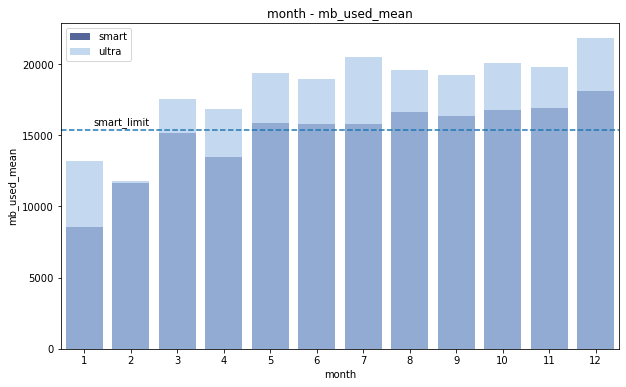

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.set_color_codes('dark')
sns.barplot(data=internet_month_sm_tr_stat, x='month', y='mb_used_mean', color='b', alpha=0.7, label='smart', \
            capsize=200)

sns.set_color_codes('pastel')
sns.barplot(data=internet_month_ul_tr_stat, x='month', y='mb_used_mean', color='b', alpha=0.7, label='ultra')

ax.set_title('month - mb_used_mean')
ax.axhline(15*1024, ls='--')
ax.text(0.2, 15*1024 + 400, "smart_limit")
ax.legend(ncol=1)

Для интернет трафика все не так однозначно. Видно, что для тарифа smart среднее значение чуть первышает установленнй лимит. Это означает, что людем не хватает трафика, и они готовы доплавичать за него. Для тарифа ultra среднее значение меньше, чем лимит в 30 Гб. В целом это показывает, что по данному показателю люди будут выбирать уже исходя из потребностей каждого. Необходимо оценить, сколько пользователь готов платить за превышенные гигабайты и на сколько это соотносится с абонентской платой тарифа ultra.

### Вывод

На данном шаге были проанализированы распределения трех главных показателей (длительность звонков, количество сообщений и объем интеренет трафика) за месяц. По ним видно, что тариф smart покрывает потребности большинства пользователей в звонках и сообщениях. Пользователи в среднем используют не в полной мере предоставленную услугу. Что касается интернета, здесь люди используют сверх лимита для тарифа smart, но не так много, как установлено в ultra.

<a id="step4"></a>
## 4. Проверка гипотез

Проверим гипотезу: "Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается"
<br>
<br>
Нулевая гипотеза: "Средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт"<br>
H0: X_ultra = X_smart (X - среднее значение)
<br> 
Альтернативная гипотеза: "Средняя выручка пользователей тарифа Ультра" не равна средней выручке пользователей тарифа "Смарт"<br>
H1: X_ultra != X_smart (X - среднее значение)

In [42]:
# Критический уровень статистической значимости задайте значением 0.05.
alpha = .05

result_hypothesis_1 = st.ttest_ind(smart_tariff['count_revenue'], ultra_tariff['count_revenue'], equal_var=True)
print('p-значение:', result_hypothesis_1.pvalue)
if result_hypothesis_1.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


Полученное значение говорит нам, что средние двух выборок не равны. Наше предположение не верно и у нас есть основание дальше не рассматривать эту гипотезу. Получить выборки, при которых средние будут равны можно с вероятностью 2.9776448000521676e-156. 

In [43]:
# Отдельно посмотрим на средние значения этих выборок
display(smart_tariff['count_revenue'].describe())
print()
display(ultra_tariff['count_revenue'].describe())

count    2229.000000
mean     1294.639300
std       820.933202
min       550.000000
25%       550.000000
50%      1038.000000
75%      1750.000000
max      6770.000000
Name: count_revenue, dtype: float64

count     985.000000
mean     2071.065990
std       378.802377
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: count_revenue, dtype: float64

Проверим гипотезу: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"
<br>
<br>
Нулевая гипотеза: "Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов<br>
H0: X_moscow = X_other (X - среднее значение)
<br>
Альтернативная гипотеза: "Средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов<br>
H1: X_moscow != X_other (X - среднее значение)

In [44]:
# Добавим город для каждого пользователя
full_data_gp = full_data_gp.merge(users[['user_id', 'city']], on='user_id', how='left')
display(full_data_gp.head(10))

,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,sum_of_mb_used,tariff,count_revenue,city
0,1000,5,159,17,22,2256,ultra,1950.0,Краснодар
1,1000,6,172,28,60,23257,ultra,1950.0,Краснодар
2,1000,7,340,41,75,14016,ultra,1950.0,Краснодар
3,1000,8,408,42,81,14070,ultra,1950.0,Краснодар
4,1000,9,466,46,57,14581,ultra,1950.0,Краснодар
5,1000,10,350,44,73,14717,ultra,1950.0,Краснодар
6,1000,11,338,37,58,14768,ultra,1950.0,Краснодар
7,1000,12,333,38,70,9827,ultra,1950.0,Краснодар
8,1001,11,430,45,0,18452,smart,1350.0,Москва
9,1001,12,414,47,0,14053,smart,550.0,Москва


In [45]:
# получим таблицу для Москвы и остальных городов
moscow_stat = full_data_gp.query('city == "Москва"')
other_city_stat = full_data_gp.query('city != "Москва"')

display(moscow_stat.head())
display(other_city_stat.head())

,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,sum_of_mb_used,tariff,count_revenue,city
8,1001,11,430,45,0,18452,smart,1350.0,Москва
9,1001,12,414,47,0,14053,smart,550.0,Москва
17,1003,8,380,43,37,8571,ultra,1950.0,Москва
18,1003,9,961,105,91,12479,ultra,1950.0,Москва
19,1003,10,855,97,83,14779,ultra,1950.0,Москва


,user_id,month,sum_calls_duration,num_of_calls,num_of_messages,sum_of_mb_used,tariff,count_revenue,city
0,1000,5,159,17,22,2256,ultra,1950.0,Краснодар
1,1000,6,172,28,60,23257,ultra,1950.0,Краснодар
2,1000,7,340,41,75,14016,ultra,1950.0,Краснодар
3,1000,8,408,42,81,14070,ultra,1950.0,Краснодар
4,1000,9,466,46,57,14581,ultra,1950.0,Краснодар


In [46]:
# Критический уровень статистической значимости задайте значением 0.05.
alpha = .05

result_hypothesis_2 = st.ttest_ind(moscow_stat['count_revenue'], other_city_stat['count_revenue'], equal_var=True)
print('p-значение:', result_hypothesis_2.pvalue)
if result_hypothesis_2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Полученное значение дает нам основание полагать, что гипотеза может быть верна. Мы ее не отвергаем. С вероятностью 53% и выше такое различие между средними двух выборок можно получить случайно. Т.к. пороговое значение мы приняли 5%, полученная вероятность слишком большая, чтобы отвергать данную гипотезу.

In [47]:
# Отдельно посмотрим на средние значения этих выборок
display(moscow_stat['count_revenue'].describe())
print()
display(other_city_stat['count_revenue'].describe())

count     611.000000
mean     1550.805237
std       752.451347
min       550.000000
25%       798.000000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: count_revenue, dtype: float64

count    2603.000000
mean     1528.316942
std       810.411374
min       550.000000
25%       750.000000
50%      1587.000000
75%      1950.000000
max      6770.000000
Name: count_revenue, dtype: float64

### Вывод

На данном шаге были проверены 2 гипотезы. Первую гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, мы не отвергаем, потому что вероятность получить равные значения средней выручки очень мала. Вторую гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, не подтверждена данными и мы можем в дальнейшем ее не рассматривать.

<a id="step5"></a>
## 5. Общий вывод

В данной работе мы изучали поведение клиентов оператора сотовой связи для двух тарифов по небольшой выборке. Данные предобработаны и подготовлены для дальнейшего анализа. На основе уже имеющихся данных, были посчтаны дополнительные показатели. После были подробно рассмотрены оба тарифа, посчитаны средние значения, дисперсии и стандартные отклонения основных параметров - длительности звонков, количества сообщений и объем интернет трафика. На основании полученной информации, можно увидеть, что тариф "Смарт" более подходит под потребности пользователей.<br>
Были провереы две гипотезы для данной выборки. У нас есть все основания полагать что выручка пользователей тарифов «Ультра» и «Смарт» различаются, а также что выручка не зависит от города, в котором проживает пользователь оператора.